In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from google.colab import files

# Upload file
uploaded = files.upload()

# Get uploaded filename dynamically
import io
filename = list(uploaded.keys())[0]  # get uploaded file name
df = pd.read_csv(io.StringIO(uploaded[filename].decode('utf-8')))

# Use only relevant columns
df = df[['Resume', 'Category']]

# Encode labels
categories = df['Category'].unique()
category_to_int = {cat: i for i, cat in enumerate(categories)}
int_to_category = {i: cat for cat, i in category_to_int.items()}
df['label'] = df['Category'].map(category_to_int)

# Clean resume text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  # remove punctuation and lowercase
    text = re.sub(r'\d+', '', text)              # remove numbers
    return text

df['cleaned'] = df['Resume'].apply(clean_text)


Saving UpdatedResumeDataSet.csv to UpdatedResumeDataSet.csv


In [2]:
# Tokenize
df['tokens'] = df['cleaned'].apply(lambda x: x.split())

# Build vocabulary (top 1000 words)
all_tokens = [token for tokens in df['tokens'] for token in tokens]
vocab_counter = Counter(all_tokens)
vocab = [word for word, freq in vocab_counter.most_common(1000)]
word_to_index = {word: idx for idx, word in enumerate(vocab)}


In [3]:
def vectorize(tokens):
    vec = np.zeros(len(vocab))
    for word in tokens:
        if word in word_to_index:
            vec[word_to_index[word]] += 1
    return vec

X = np.array([vectorize(tokens) for tokens in df['tokens']])
y = df['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, epochs=100):
        self.lr = lr
        self.epochs = epochs
        self.loss_history = []
        self.accuracy_history = []
        self.rmse_history = []
        self.test_accuracy_history = []

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy(self, y_hat, y):
        m = y.shape[0]
        return -np.sum(y * np.log(y_hat + 1e-15)) / m

    def one_hot(self, y, num_classes):
        one_hot_y = np.zeros((y.size, num_classes))
        one_hot_y[np.arange(y.size), y] = 1
        return one_hot_y

    def fit(self, X, y, X_test=None, y_test=None):
        m, n = X.shape
        num_classes = len(np.unique(y))
        y_encoded = self.one_hot(y, num_classes)
        self.W = np.zeros((n, num_classes))
        self.b = np.zeros((1, num_classes))

        for i in range(self.epochs):
            logits = np.dot(X, self.W) + self.b
            probs = self.softmax(logits)

            loss = self.cross_entropy(probs, y_encoded)
            self.loss_history.append(loss)

            y_pred_labels = np.argmax(probs, axis=1)
            acc = np.mean(y_pred_labels == y)
            rmse = np.sqrt(np.mean((y_pred_labels - y) ** 2))

            self.accuracy_history.append(acc)
            self.rmse_history.append(rmse)

            # Test accuracy
            if X_test is not None and y_test is not None:
                test_logits = np.dot(X_test, self.W) + self.b
                test_probs = self.softmax(test_logits)
                test_preds = np.argmax(test_probs, axis=1)
                test_acc = np.mean(test_preds == y_test)
                self.test_accuracy_history.append(test_acc)
                print(f"Epoch {i+1}: Loss={loss:.4f}, Train Acc={acc:.4f}, Test Acc={test_acc:.4f}, RMSE={rmse:.4f}")
            else:
                self.test_accuracy_history.append(None)
                print(f"Epoch {i+1}: Loss={loss:.4f}, Train Acc={acc:.4f}, RMSE={rmse:.4f}")

            # Backpropagation
            gradient_w = np.dot(X.T, (probs - y_encoded)) / m
            gradient_b = np.sum(probs - y_encoded, axis=0, keepdims=True) / m

            self.W -= self.lr * gradient_w
            self.b -= self.lr * gradient_b

    def predict(self, X):
        logits = np.dot(X, self.W) + self.b
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)


In [5]:
model = LogisticRegressionScratch(lr=0.1, epochs=30)
model.fit(X_train, y_train, X_test, y_test)


Epoch 1: Loss=3.2189, Train Acc=0.0455, Test Acc=0.0259, RMSE=14.3788
Epoch 2: Loss=9.2961, Train Acc=0.0676, Test Acc=0.0829, RMSE=7.4892
Epoch 3: Loss=4.7515, Train Acc=0.2614, Test Acc=0.2021, RMSE=8.6849
Epoch 4: Loss=6.0658, Train Acc=0.4031, Test Acc=0.2953, RMSE=8.3401
Epoch 5: Loss=6.2724, Train Acc=0.5410, Test Acc=0.4922, RMSE=7.0946
Epoch 6: Loss=6.2309, Train Acc=0.5722, Test Acc=0.5389, RMSE=7.4145
Epoch 7: Loss=3.9037, Train Acc=0.6099, Test Acc=0.5699, RMSE=6.4935
Epoch 8: Loss=3.0090, Train Acc=0.6983, Test Acc=0.6580, RMSE=6.7049
Epoch 9: Loss=2.1106, Train Acc=0.7269, Test Acc=0.6788, RMSE=5.3001
Epoch 10: Loss=1.5743, Train Acc=0.8414, Test Acc=0.7876, RMSE=3.7267
Epoch 11: Loss=1.1658, Train Acc=0.8791, Test Acc=0.8394, RMSE=3.3278
Epoch 12: Loss=0.7821, Train Acc=0.9402, Test Acc=0.9223, RMSE=1.7714
Epoch 13: Loss=0.6361, Train Acc=0.9519, Test Acc=0.9326, RMSE=1.8128
Epoch 14: Loss=0.5761, Train Acc=0.9662, Test Acc=0.9585, RMSE=0.7624
Epoch 15: Loss=0.5490, Train

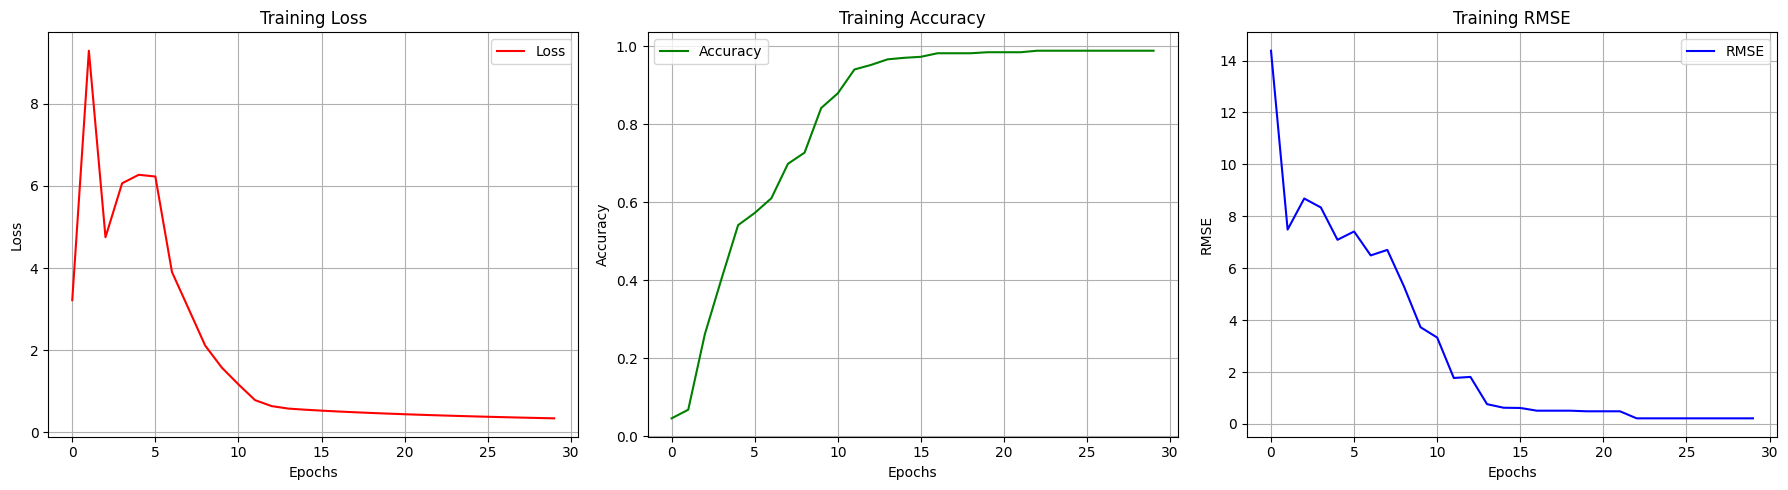

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(model.loss_history, label="Loss", color='red')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(model.accuracy_history, label="Accuracy", color='green')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(model.rmse_history, label="RMSE", color='blue')
plt.title("Training RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
y_pred = model.predict(X_test)

# Accuracy
accuracy = np.mean(y_pred == y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

# Confusion Matrix
conf_matrix = np.zeros((len(categories), len(categories)), dtype=int)
for true, pred in zip(y_test, y_pred):
    conf_matrix[true][pred] += 1

print("\nConfusion Matrix:")
print(conf_matrix)

# Classification Report
for i in range(len(categories)):
    tp = conf_matrix[i][i]
    fp = np.sum(conf_matrix[:, i]) - tp
    fn = np.sum(conf_matrix[i, :]) - tp
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    print(f"{int_to_category[i]:<25} Precision: {precision:.2f} Recall: {recall:.2f} F1: {f1:.2f}")



Test Accuracy: 0.9741

Confusion Matrix:
[[ 5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0 10  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0
   0

In [8]:
def predict_resume(text):
    tokens = clean_text(text).split()
    vec = vectorize(tokens).reshape(1, -1)
    pred = model.predict(vec)[0]
    return int_to_category[pred]

resume_text = """
Highly skilled MERN Stack Developer with experience in React, Node.js, Firebase and MongoDB.
"""

print("\nPredicted Category:", predict_resume(resume_text))



Predicted Category: Java Developer


In [9]:
def predict_resume(text):
    tokens = clean_text(text).split()
    vec = vectorize(tokens).reshape(1, -1)
    pred = model.predict(vec)[0]
    return int_to_category[pred]

resume_text = """
Highly skilled in Drawing.
"""

print("\nPredicted Category:", predict_resume(resume_text))



Predicted Category: Arts


In [10]:
def predict_resume(text):
    tokens = clean_text(text).split()
    vec = vectorize(tokens).reshape(1, -1)
    pred = model.predict(vec)[0]
    return int_to_category[pred]

resume_text = """
Highly skilled in Developing new products,tools and technologies.
"""

print("\nPredicted Category:", predict_resume(resume_text))



Predicted Category: Arts


In [11]:
print("\nSome misclassified resumes:")
misclassified_indices = np.where(y_pred != y_test)[0][:5]
for idx in misclassified_indices:
    true_label = int_to_category[y_test[idx]]
    pred_label = int_to_category[y_pred[idx]]
    print(f"True: {true_label}, Predicted: {pred_label}")
    print("Snippet:", " ".join(df.iloc[idx]['tokens'][:20]), "\n")



Some misclassified resumes:
True: Advocate, Predicted: HR
Snippet: personal skills â ability to quickly grasp technical aspects and willingness to learn â high energy levels result oriented education 

True: HR, Predicted: Arts
Snippet: expertise â data and quantitative analysis â decision analytics â predictive modeling â datadriven personalization â kpi dashboards â big 

True: HR, Predicted: Arts
Snippet: education details btech rayat and bahra institute of engineering and biotechnology data science data science skill details numpy exprience less 

True: Advocate, Predicted: HR
Snippet: skills â knows english as native speaker ielts overall listening reading writing and speaking hindi with bilingual proficiency and punjabi 

True: DevOps Engineer, Predicted: Business Analyst
Snippet: education details january rachana sansad school of interior deign january holy family high school master of commerce marketing mumbai maharashtra 



In [12]:
from sklearn.model_selection import train_test_split

# Assuming X and y are already defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# After training
y_pred = model.predict(X_test)

# Accuracy on test data
acc = np.mean(y_pred == y_test)
print("Test Accuracy:", acc)


Test Accuracy: 0.9740932642487047


In [14]:
y_pred = model.predict(X_train)  # ← Yeh overfitting dega


In [15]:
# Check unique labels before training
print(np.unique(y_train))
print(np.unique(y_test))


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [16]:
print("Train size:", len(X_train))
print("Test size:", len(X_test))


Train size: 769
Test size: 193


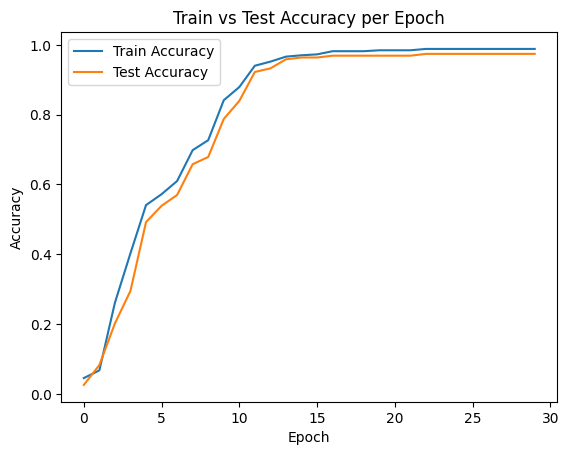

In [17]:
plt.plot(model.accuracy_history, label='Train Accuracy')
plt.plot(model.test_accuracy_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Test Accuracy per Epoch')
plt.show()


In [18]:
import pickle

# Save the model to a file
with open("logistic_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Model saved as logistic_model.pkl")


✅ Model saved as logistic_model.pkl
